# Topic Modeling of the television show Stargate SG1

## Motivations

I love the show Stargate SG1.  It is humorous with a level of self-awareness and does not take itself seriously, unlike some other sci-fi shows such as (Battlestar Gallactica or Stargate Universe).  Every year or so, I randomly re-watch the different seasons of the show.

The show ran for 10 seasons with a total of 214 episodes.  It spanned multiple worlds as the SG1 team traveled and met with multiple alien races, some are friendly, some are evil.  It also had its own lores involving alien technologies, alien vocabularies, US military vocabularies, ancient Egyptian mythologies and pop-culture references.  

Additionally, the episodes are generally self-contained, with the maximum that a storyline spans is around 2-3 episodes.  This makes the show easy to re-watch or to pick up at random spots without having to be updated of all the backgrounds and pertinent details.

The motivation of this project is to build a corpus of all the transcripts of the 10 seasons, explore if there are recurrent themes and group the episodes and/or seasons by them.  By doing so, I'm looking to map the essential words for each theme and also the episodes relating to each theme.  This would allow one to select a group of theme or storyline and be able to watch all the episodes relating to it.

## Overview

The following steps will be taken to explore this project:

- Create Pipeline to scrape the transcript data
- Preprocess and build a corpus of all the episodes
- Tokenize and create a dictionary of all the words used in the episodes
- Train and build embeddings from the tokens
- Model the topics
- Finally, explore the undercurrent themes and topics results

### Data Source

http://www.stargate-sg1-solutions.com/wiki/Transcripts appears to have the most complete transcripts for all 10 seasons.  The transcripts were compiled and archived by fans of the show.


## Step 0: imports

In [1]:
import sys
import re
import pathlib
import pickle
from typing import Iterator
import ftfy
from tqdm.auto import trange, tqdm
import numpy as np
import polars as pl
import plotly.express as px
import gensim
from gensim.models.fasttext import FastText
import spacy
from spacy.attrs import ORTH, NORM
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.manifold import trustworthiness
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
import hdbscan
import trafilatura
from trafilatura import spider
import courlan
import gc

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

import umap


gc.enable()
gc.collect()

53163

## Step 1: Pipeline to Scrape Data

The scraping process involves:
- fetching the URL
- extract the links
- create a unique set of links
- filter the links for only the ones that have "Transcript" in the URL
- extract the transcripts
- do some preliminary cleaning of the transcripts such as fixing Unicode issues and other things
- then saving the transcripts to a pickle file

In [2]:
def get_transcript_links(urls: list) -> Iterator[set]:
    """
    get all the links for each season's page
    yield (generator) of sets
    """
    for season in urls:
        season_page = trafilatura.fetch_url(season, decode=True)
        links = spider.extract_links(
            pagecontent=season_page,
            base_url="http://www.stargate-sg1-solutions.com",
            external_bool=False,
        )
        yield links


def merge_uniqefy_links(links: Iterator[set]) -> set[str]:
    """
    merge the list of sets
    return a single set of unique links
    """
    all_links = set()
    for season in links:
        all_links.update(season)

    return all_links


def filter_links(links: set[str]) -> Iterator:
    """
    filter to only obtain the transcript links
    transcript url is of pattern: "wiki/[0-9].*Transcript"
    yield (generator) of links
    """
    link_pattern = re.compile(r"wiki\/\d.+Transcript$")

    for l in links:
        if re.search(link_pattern, l):
            yield l


def extract_transcripts(filtered_links: set[str]) -> Iterator[dict]:
    """
    extract the actual transcript from the set of transcript links
    yield (generator) of dicts
    """
    for l in filtered_links:
        page = trafilatura.fetch_url(l)
        extracted_page = trafilatura.bare_extraction(page)
        yield extracted_page


def clean_transcripts(transcripts: list[dict]) -> Iterator[dict]:
    # used to join character name with adjacent line where they talk
    pattern_1 = re.compile(r"(\n[A-Z]+.*[A-Z0-9]+)(\n)")

    # used to join character's reaction with adjacent line where they talk
    pattern_2 = re.compile(r"(\(.*\))\n")

    # used to match and select the stopping point of the transcripts
    pattern_3 = re.compile(r"^(Transcribe|(ROLL|END)\sCREDIT|FADE OUT).*")

    # correct some names:
    names = {"ONEILL": "O'NEILL", "TEALC": "TEAL'C", "BRATAC": "BRA'TAC"}

    for episode in transcripts:
        episode["text"] = ftfy.fix_text(episode["text"])

        for name in names:
            episode["text"] = re.sub(name, names[name], episode["text"])

        episode["text"] = re.sub(pattern_1, r"\1 ", episode["text"])
        episode["text"] = re.sub(pattern_2, r"\1 ", episode["text"])
        episode["text"] = episode["text"].split("\n")
        start_index = episode["text"].index("Transcript") + 1
        for n, e in enumerate(episode["text"]):
            if re.search(pattern_3, e):
                end_index = n - 1
        episode["text"] = episode["text"][start_index:end_index]
        yield episode


def run_extraction_pipeline(urls: list) -> list[dict]:
    # list of dicts
    # with the actual transcript stored in the dict's "text" key
    extracted_transcripts = list(
        clean_transcripts(
            extract_transcripts(
                filter_links(merge_uniqefy_links(get_transcript_links(urls)))
            )
        )
    )

    # sort the transcripts by episode title
    sorted_transcripts = sorted(extracted_transcripts, key=lambda x: x["title"])

    # pickle the transcripts
    with open("extracted_sg1_transcripts.pkl", "wb") as f:
        pickle.dump(sorted_transcripts, f)

    # transcripts is a list of dicts that include other metadata
    # with the key "text" containing the actual transcript
    return sorted_transcripts

In [3]:
urls = [
    "http://www.stargate-sg1-solutions.com/wiki/Season_One_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Two_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Three_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Four_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Five_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Six_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Seven_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Eight_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Nine_Transcripts",
    "http://www.stargate-sg1-solutions.com/wiki/Season_Ten_Transcripts",
]


try:
    # load transcripts
    with open("step_01_extracted_sg1_transcripts.pkl", "rb") as f:
        transcripts = pickle.load(f)
except:
    transcripts = run_extraction_pipeline(urls)

## Step 1.5: Exploring the characters' statistics over the series

In the code below, I go through the transcripts and:
- extract how many times a character speaks for every episode
- extract how many words a character speaks for every episode
- calculate a "long-windedness" metric by taking a ratio of number of words / number of times talking
- put all the above into a Polars DataFrame

In [4]:
# Create a Polars dataframe to store statistics such as
# the number of times spoken and how many words are spoken

char_stats = pl.DataFrame()
char_regex_pattern = re.compile(r"([A-Z]+)([\-—\']*)([A-Z]+)")

for ep in transcripts:
    title = ep["title"]
    who_talks_most = {}
    who_talks_longest = {}

    for t in ep["text"]:
        mo = re.match(char_regex_pattern, t)
        if mo:
            words = len(re.sub(char_regex_pattern, "", t).split())
            if (mo.group() in who_talks_most.keys()) and (
                mo.group() in who_talks_longest.keys()
            ):
                who_talks_most[mo.group()] += 1
                who_talks_longest[mo.group()] += words
            else:
                who_talks_most[mo.group()] = 1
                who_talks_longest[mo.group()] = words

    char_stats = pl.concat(
        [
            char_stats,
            pl.DataFrame(
                {
                    "title": title,
                    "name": who_talks_most.keys(),
                    "frequency": who_talks_most.values(),
                    "words": who_talks_longest.values(),
                }
            ),
        ],
        how="vertical",
    )

char_stats = (
    char_stats.with_columns(pl.col("title").str.split(by=" "))
    .select(
        pl.col("title").list.get(0).cast(pl.Utf8).alias("episode").str.zfill(5),
        pl.col("name"),
        pl.col("frequency"),
        pl.col("words"),
    )
    .filter(
        ~pl.col("name").str.contains(
            "BEGIN|INT|EXT|ETX|TEASER|END|ROLL|FADE|CREDITS|FLASHBACK|ALTERNATE"
        )
    )
    .sort(["episode"], descending=False)
)

char_stats = char_stats.select(
    pl.col("episode").str.slice(0, 2).alias("season"),
    pl.col("episode").str.slice(3, 2).alias("episode"),
    pl.col("name"),
    pl.col("frequency"),
    pl.col("words"),
)

In [5]:
char_stats.head()

season,episode,name,frequency,words
str,str,str,i64,i64
"""01""","""01""","""AIRMAN""",21,148
"""01""","""01""","""FEMALE""",8,96
"""01""","""01""","""APOPHIS""",18,71
"""01""","""01""","""SF""",1,2
"""01""","""01""","""HAMMOND""",81,1024


### Over all Seasons by characters who speak the most and has the most words

- Here I create a "over_all_seasons" DataFrame for the characters that have spoken more than 2,000 words over the entire series
- Then I plotted out the bar charts of the number of words, number of times speaking and long-windedness of the characters

In [6]:
# over all seasons by characters who speak the most and has the most words
over_all_seasons = (
    char_stats.groupby(["name"])
    .sum()
    .select(
        pl.col("name"),
        pl.col("frequency"),
        pl.col("words"),
        (pl.col("words") / pl.col("frequency")).alias("words/frequency"),
    )
    .sort(["frequency", "words", "words/frequency"], descending=[True, True, True])
    .filter(pl.col("words") >= 2000)
)

In [7]:
over_all_seasons.head()

name,frequency,words,words/frequency
str,i64,i64,f64
"""O'NEILL""",12285,91419,7.441514
"""CARTER""",11036,122351,11.086535
"""DANIEL""",9755,109895,11.265505
"""TEAL'C""",4724,46217,9.783446
"""HAMMOND""",3501,38411,10.971437


Over all seasons, Samantha Carter uses the most words.

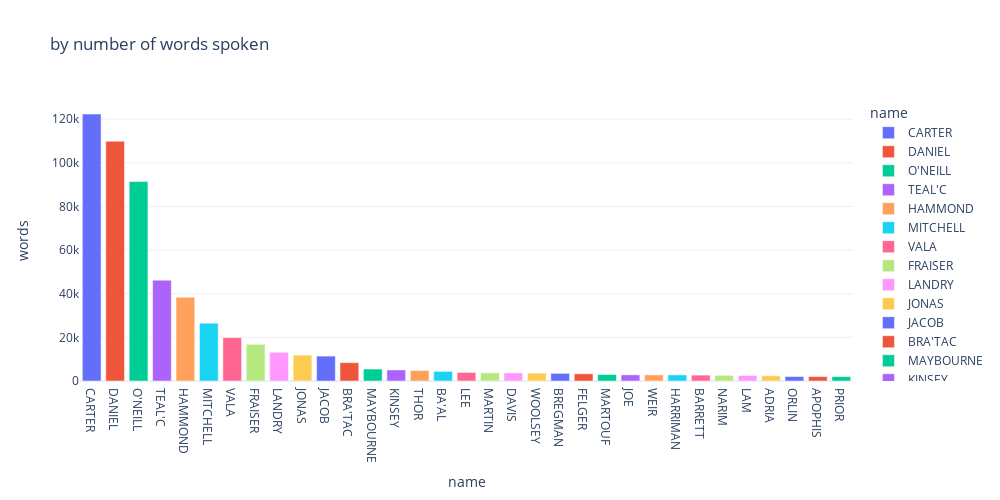

In [8]:
gc.collect()
fig = px.bar(
    over_all_seasons.sort("words", descending=True),
    x="name",
    y="words",
    color="name",
    title="by number of words spoken",
    template="plotly_white",
    width=1000,
    height=500,
)

fig.show("png")

However, Over all seasons, Jack O'Neill talks the most often.

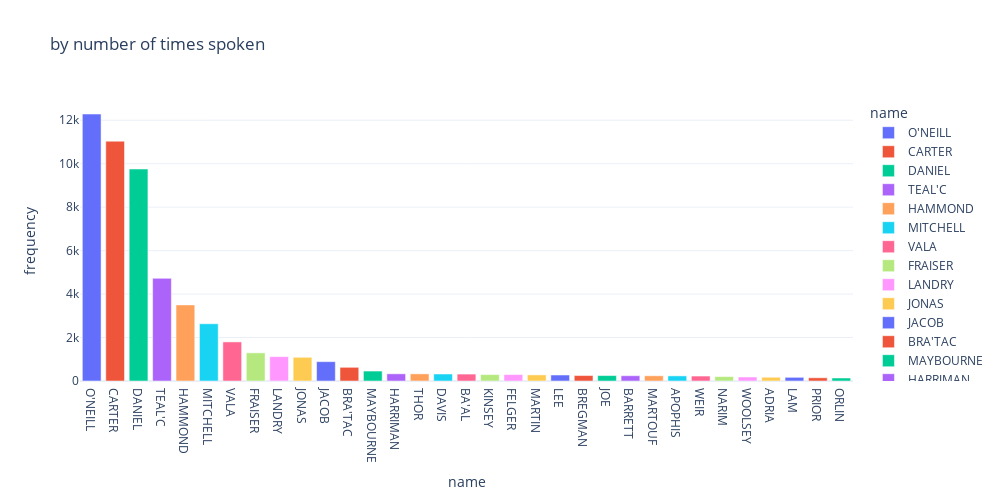

In [9]:
gc.collect()
fig = px.bar(
    over_all_seasons.sort("frequency", descending=True),
    x="name",
    y="frequency",
    color="name",
    title="by number of times spoken",
    template="plotly_white",
    width=1000,
    height=500,
)
fig.show("png")

Long-winded-ness is defined as the number of words spoken / number of times spoken.

To no-one's surprise, the politicians of the show (Richard Woolsey and Senator Kinsey) are the most long-winded, using the most words for the little time that they talk.

On the other end of the spectrum, O'Neill is the most efficient with words.

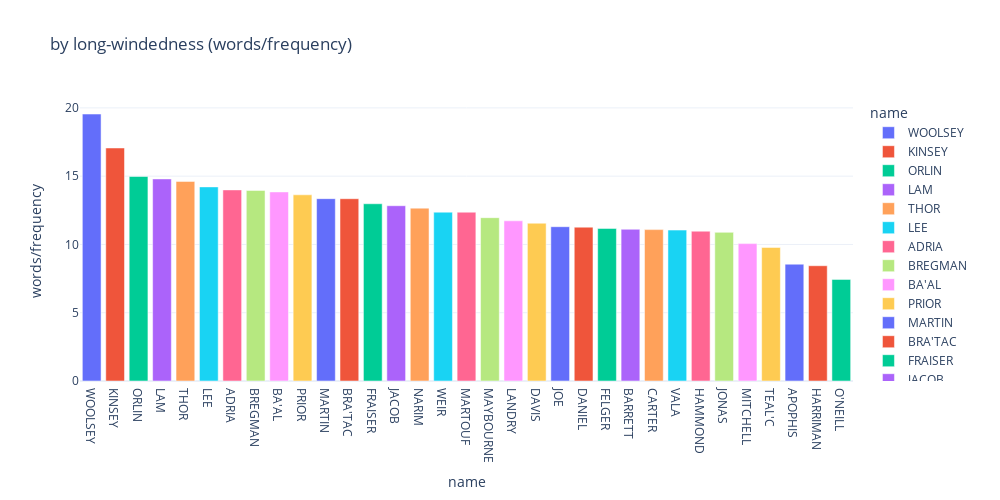

In [10]:
gc.collect()
fig = px.bar(
    over_all_seasons.sort("words/frequency", descending=True),
    x="name",
    y="words/frequency",
    color="name",
    title="by long-windedness (words/frequency)",
    template="plotly_white",
    width=1000,
    height=500,
)

fig.show("png")

### Break down by each season

- Below, I create a "by_season" DataFrame to create bar charts of each character's involvement over the seasons
- Additionally, another way of illustrating this is by heatmaps, as observed below

In [11]:
# by each season and characters who speak the most and has the most words
by_season = (
    char_stats.groupby(["season", "name"])
    .sum()
    .select(
        pl.col("season"),
        pl.col("name"),
        pl.col("frequency"),
        pl.col("words"),
        (pl.col("words") / pl.col("frequency")).alias("words/frequency"),
    )
    .sort(["season", "frequency", "words"], descending=[False, True, True])
)

In [12]:
by_season.head()

season,name,frequency,words,words/frequency
str,str,i64,i64,f64
"""01""","""O'NEILL""",1902,15563,8.18244
"""01""","""DANIEL""",1284,14515,11.304517
"""01""","""CARTER""",1176,11989,10.194728
"""01""","""TEAL'C""",600,5893,9.821667
"""01""","""HAMMOND""",598,7246,12.117057


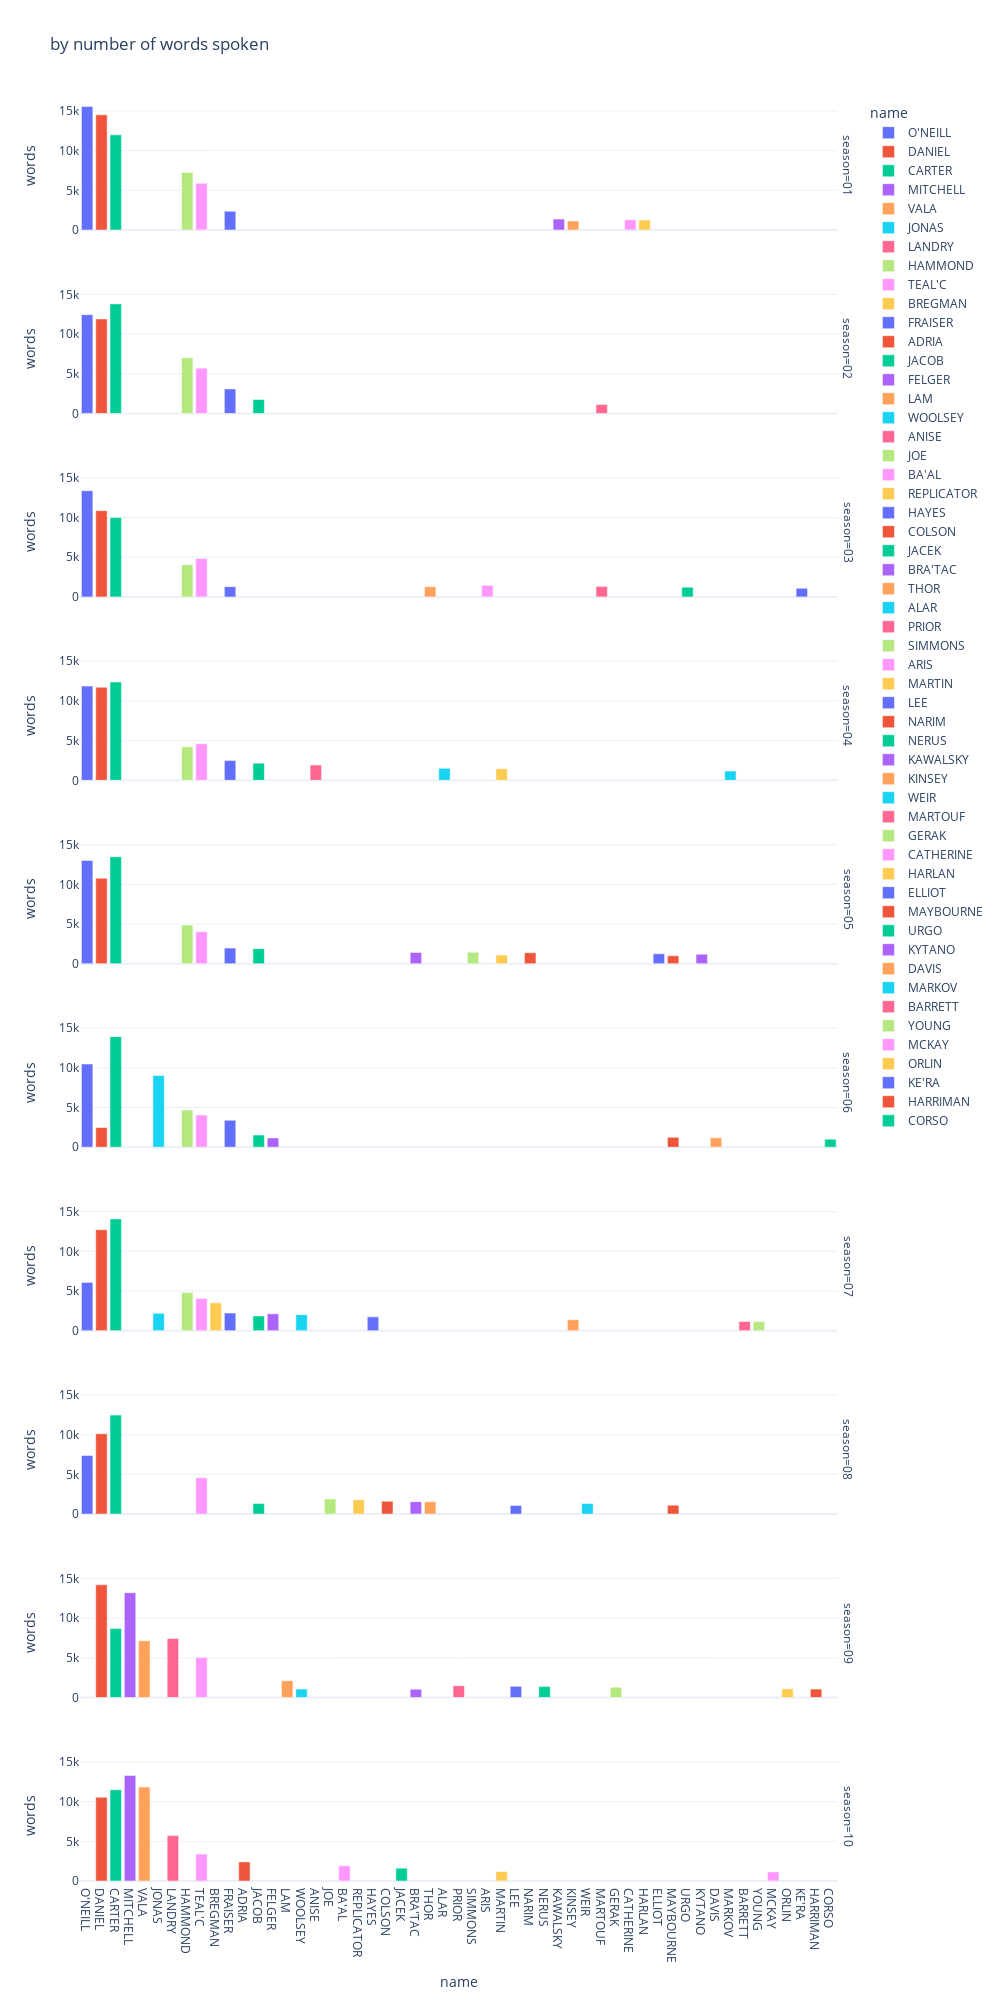

In [13]:
gc.collect()
fig = px.bar(
    by_season.sort("words", descending=True).filter(pl.col("words") >= 1000),
    x="name",
    y="words",
    color="name",
    title="by number of words spoken",
    facet_row="season",
    template="plotly_white",
    category_orders={
        "season": by_season.select(pl.col("season"))
        .unique()
        .sort("season")
        .to_series()
        .to_list()
    },
    width=1000,
    height=2000,
)

fig.show("png")

### Heatmap of characters and number of words spoken over the seasons

In [14]:
words = (
    by_season.select(pl.exclude(["frequency", "words/frequency"]))
    .filter(
        pl.col("name").is_in(
            over_all_seasons.select(pl.col("name")).to_series().to_list()
        )
    )
    .pivot(index="season", columns="name", values="words", aggregate_function=None)
    .fill_null(0)
)

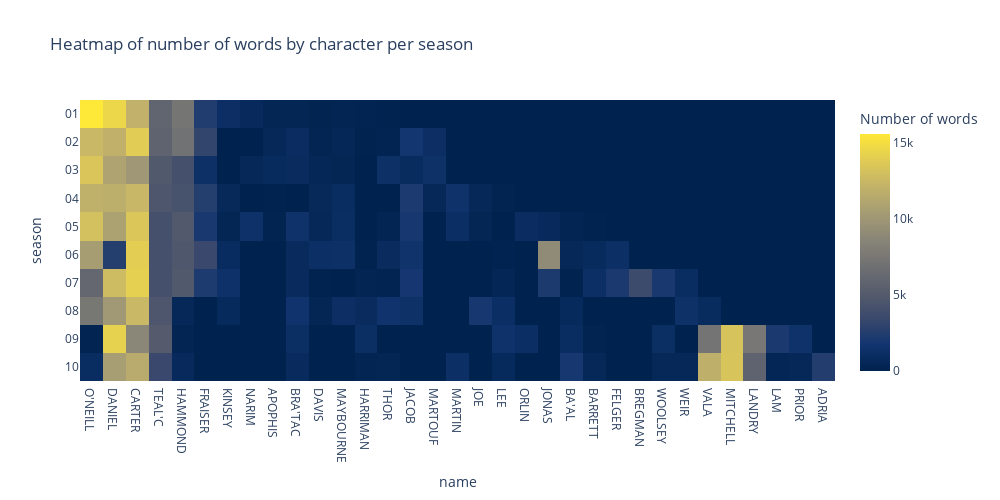

In [15]:
gc.collect()
fig = px.imshow(
    words.select(pl.exclude("season")).to_numpy(),
    width=1000,
    height=500,
    aspect="auto",
    x=words.columns[1:],
    y=words.select(pl.col("season")).to_series().to_list(),
    title="Heatmap of number of words by character per season",
    color_continuous_scale=px.colors.sequential.Cividis,
    labels=dict(x="name", y="season", color="Number of words"),
    template="plotly_white",
)

fig.show("png")

### Heatmap of how much more talkative a character becomes over the seasons

In [16]:
talktative = (
    by_season.select(pl.exclude(["words", "frequency"]))
    .filter(
        pl.col("name").is_in(
            over_all_seasons.select(pl.col("name")).to_series().to_list()
        )
    )
    .pivot(
        index="season",
        columns="name",
        values="words/frequency",
        aggregate_function=None,
    )
    .fill_null(0)
)

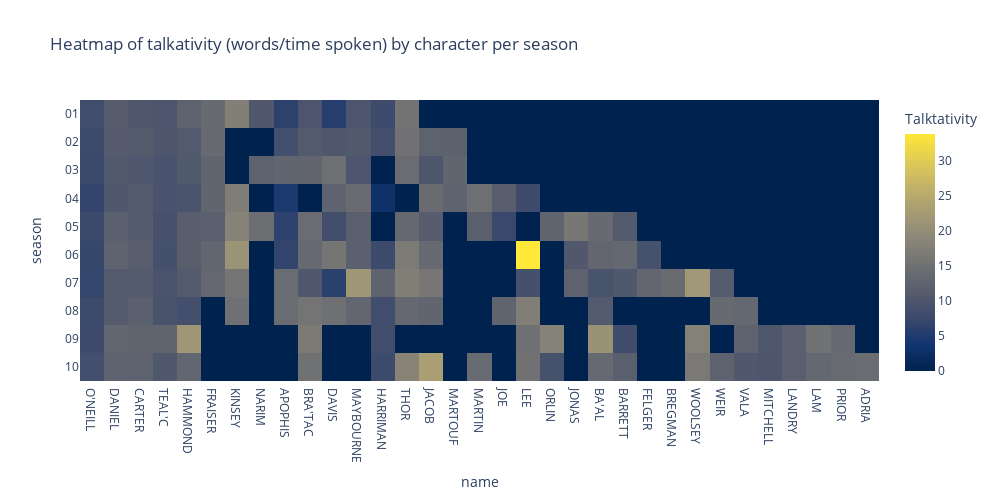

In [17]:
gc.collect()
fig = px.imshow(
    talktative.select(pl.exclude("season")).to_numpy(),
    width=1000,
    height=500,
    aspect="auto",
    x=talktative.columns[1:],
    y=talktative.select(pl.col("season")).to_series().to_list(),
    title="Heatmap of talkativity (words/time spoken) by character per season",
    color_continuous_scale=px.colors.sequential.Cividis,
    labels=dict(x="name", y="season", color="Talktativity"),
    template="plotly_white",
)

fig.show("png")

## Step 2: Preprocess and Build Corpus

- For the topic modeling, I don't care who the speaker is, I only care about the contents (i.e. topics) that are being spoken.
- Therefore, the below function is used to clean the transcripts of the speaker's names and other minor stuffs such as multiple white spaces.

In [18]:
def clean_corpus(corpus: Iterator[str]) -> Iterator[str]:
    # match the beginning
    pattern_1 = re.compile(r"(TEASER|FADE\sIN)")

    # match the speaker's name
    pattern_2 = re.compile(r"[A-Z]{2,}")

    # match two or more spaces
    pattern_3 = re.compile(r"(\s{2,})")

    for doc in corpus:
        doc = re.sub(pattern_1, "", doc).strip()
        doc = re.sub(pattern_2, "", doc).strip()
        doc = re.sub(pattern_3, " ", doc).strip()
        yield doc

- For each transcript or episode (which is a list of strings), join them together into one document.
- Then clean them.
- The end result is a corpus (list of 214 strings corresponding to the 214 episodes).

In [19]:
try:
    # load the cleaned corpus
    with open("step_02_cleaned_sg1_corpus.pkl", "rb") as f:
        corpus = pickle.load(f)
except:
    corpus = (" ".join(t["text"]) for t in transcripts)
    corpus = list(clean_corpus(corpus))

    # pickle the cleaned corpus
    with open("step_02_cleaned_sg1_corpus.pkl", "wb") as f:
        pickle.dump(corpus, f)

print(len(corpus))

214


## Step 3: Tokenize, Create Dictionary, and Build Embeddings with FB's FastText

### Tokenize

- Define function to clean the corpus of multiple whitespaces if there are any.
- The words are then screened for stopwords as well as brackets and some punctuations and return tokenized as lemma form for the whole corpus.

In [20]:
def clean_tokenize(docs: list[str]) -> Iterator[list]:
    """
    Input: docs: list of sentences
    Output: generator or list of lists of tokens
    """
    cleaned = (
        gensim.parsing.preprocessing.strip_multiple_whitespaces(doc).strip().lower()
        for doc in docs
    )

    nlp = spacy.load("en_core_web_lg", exclude=["parser", "ner", "tok2vec"])
    print(nlp.pipe_names)

    tokenizer_exceptions = {
        "o'neill": [{ORTH: "o'neill"}],
        "teal'c": [{ORTH: "teal'c"}],
        "bra'tac": [{ORTH: "bra'tac"}],
        "ba'al": [{ORTH: "ba'al"}],
        "ba'als": [{ORTH: "ba'als"}],
        "goa'uld": [{ORTH: "goa'uld"}],
        "kar'yn": [{ORTH: "kar'yn"}],
        "cor-ai": [{ORTH: "cor-ai"}],
        "heru'ur": [{ORTH: "heru'ur"}],
        "maz'rai": [{ORTH: "maz'rai"}],
        "ren au": [{ORTH: "ren au"}],
    }

    for k, v in tokenizer_exceptions.items():
        nlp.tokenizer.add_special_case(k, v)

    # all the documents (rows) in the corpus
    sents = nlp.pipe(cleaned, n_process=6)

    # only keep the lemma form of the token and if token is not a stopword or brackets or punctuations
    def ok_token(tok):
        if not tok.is_stop and not tok.is_bracket:
            return tok.lemma_
        else:
            return None

    # iterate through each document and each token
    # return list of cleaned (lemmatized) strings
    # res = (ok_token(token) for sent in sents for token in sent if ok_token(token) != None)
    res = (
        [ok_token(token) for token in sent if ok_token(token) != None] for sent in sents
    )

    # clean up
    del docs
    del nlp
    del cleaned
    return res


def build_dictionary(cleaned_dataset: Iterator[list[str]]):
    return gensim.corpora.Dictionary(cleaned_dataset)

In [21]:
try:
    with open("step_03.1_tokenized_corpus.pkl", "rb") as f:
        tokenized_corpus = pickle.load(f)
except:
    tokenized_corpus = list(clean_tokenize(corpus))
    with open("step_03.1_tokenized_corpus.pkl", "wb") as f:
        pickle.dump(tokenized_corpus, f)

print(f"number of samples in corpus {len(tokenized_corpus)}")

number of samples in corpus 214


### Train Embedding Model

- Since the TV show has its own vocabulary, I need to train the embedding model from scratch from the show's corpus
- Here, Facebook's FastText embedding model was selected because it is relatively fast and incorporates sub-word tokenization, this is good since it takes care of mispelling cases
- I chose an embedding size of 300 for no particular reasons other than that it is high enough to capture granular details

In [22]:
gc.collect()
try:
    ftmodel = FastText.load("step_03.2_fasttext_model")
except:
    ftmodel = FastText(vector_size=300, window=5, negative=10, epochs=10, workers=8)

    ftmodel.build_vocab(corpus_iterable=tokenized_corpus)

    ftmodel.train(
        corpus_iterable=tokenized_corpus,
        total_examples=ftmodel.corpus_count,
        total_words=ftmodel.corpus_total_words,
        epochs=ftmodel.epochs,
        compute_loss=True,
    )

    ftmodel.save("step_03.2_fasttext_model")

In [23]:
# Sanity Check
print(
    f"Number of docs in corpus: {ftmodel.corpus_count}\nNumber of words in corpus: {ftmodel.corpus_total_words}"
)

Number of docs in corpus: 214
Number of words in corpus: 897901


### Build Corpus Embeddings

- Since the Fasttext model returns word embeddings, need to build a corpus embedding for all the words in each document
- This is done in the functions below by averaging all the word embeddings for each episode and stack them vertically
- The end result is a (214, 300) array: 214 episodes by 300 embedding size

In [24]:
def build_word_embedding(doc: list[str], model) -> Iterator[np.ndarray]:
    for word in doc:
        yield model.wv[word]


def build_corpus_embeddings(corpus: list[list[str]], model) -> Iterator[np.ndarray]:
    for episode in corpus:
        episode_embedding = np.array(list(build_word_embedding(episode, model))).mean(
            axis=0
        )
        yield episode_embedding

In [25]:
try:
    # load the corpus embeddings
    with open("step_03.3_corpus_embeddings.pkl", "rb") as f:
        corpus_embeddings = pickle.load(f)
except:
    corpus_embeddings = np.asarray(
        list(build_corpus_embeddings(tokenized_corpus, ftmodel)), dtype=np.float64
    )
    with open("step_03.3_corpus_embeddings.pkl", "wb") as f:
        pickle.dump(corpus_embeddings, f)

Sanity check:

In [26]:
corpus_embeddings.shape

(214, 300)

## Step 4: Topic Modeling

- To model the topics of the shows, I need to cluster episodes that are similar together
- This is done via the use of HDBSCAN

### Step 4.1 Clustering of Corpus Embeddings and Hyperparameter Tuning

- First I need to reduce the number of dimensions from 300 down to 100 in order for HDBSCAN to run efficiently
- UMAP will be used for this non-linear dimensionality reduction step
- Why not just specified 100 dimensions from the Fasttext model in the first place?  Because this gives better results (validity index) since the non-linear dimensionality algorithm will arrange vectors that are closer together to be closer on the low-d space and push dissimilar vectors further apart
- the hyperparameters for both dimensionality reduction and clustering steps are tuned together
- in this case, they are `n_neighbors` of UMAP and `min_cluster_size` and `min_samples` of HDBSCAN
- UMAP's `n_components` is set to 100 and `min_dist` is set to 0.0 since I want the lower dimensional embeddings to clump close together
- The objective of the whole hyperparameter tuning process is to get the highest possible Density based clustering metric, the Validity Index, which ranges from -1 to 1
- The tuning process is done with optuna

In [27]:
from optuna.trial import TrialState


def objective(trial):
    min_size = trial.suggest_int("min_cluster_size", 2, 5)
    min_samp = trial.suggest_int("min_samples", 1, 5)
    n_comps = 100
    n_neighs = trial.suggest_int("n_neighbors", 1, 5)

    try:
        for previous_trial in trial.study.trials:
            if (
                previous_trial.state == TrialState.COMPLETE
                and trial.params == previous_trial.params
            ):
                print(
                    f"Duplicated trial: {trial.params}, return {previous_trial.value}"
                )
                return previous_trial.value

        reducer = umap.UMAP(
            n_jobs=-1, n_components=n_comps, n_neighbors=n_neighs, min_dist=0.0
        )
        reduced = reducer.fit_transform(corpus_scaled).astype(np.float64)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_size,
            min_samples=min_samp,
            prediction_data=False,
            gen_min_span_tree=False,
            memory="hdbscan_memory",
            core_dist_n_jobs=8,
        )
        clusterer.fit(reduced)
        return hdbscan.validity_index(reduced, clusterer.labels_)
    except Exception as exc:
        return -1


try:
    with open("step_04.1_study.pkl", "rb") as f:
        study = pickle.load(f)
except:
    study_name = "hdbscan_study"
    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(seed=None),
        direction="maximize",
        study_name=study_name,
    )

    corpus_scaled = StandardScaler().fit_transform(corpus_embeddings)

    study.optimize(
        func=objective,
        n_trials=200,
        n_jobs=8,
        gc_after_trial=True,
        show_progress_bar=True,
    )

    # pickle the thing
    with open("step_04.1_study.pkl", "wb") as f:
        pickle.dump(study, f)

In [28]:
print(
    f"Best validity index is: {study.best_value}\nwith the parameters {study.best_params}"
)

Best validity index is: 0.8415873459102292
with the parameters {'min_cluster_size': 2, 'min_samples': 2, 'n_neighbors': 2}


A contour plot of the HDBSCAN hyperparameter space, with the color being the objective value (validity index).

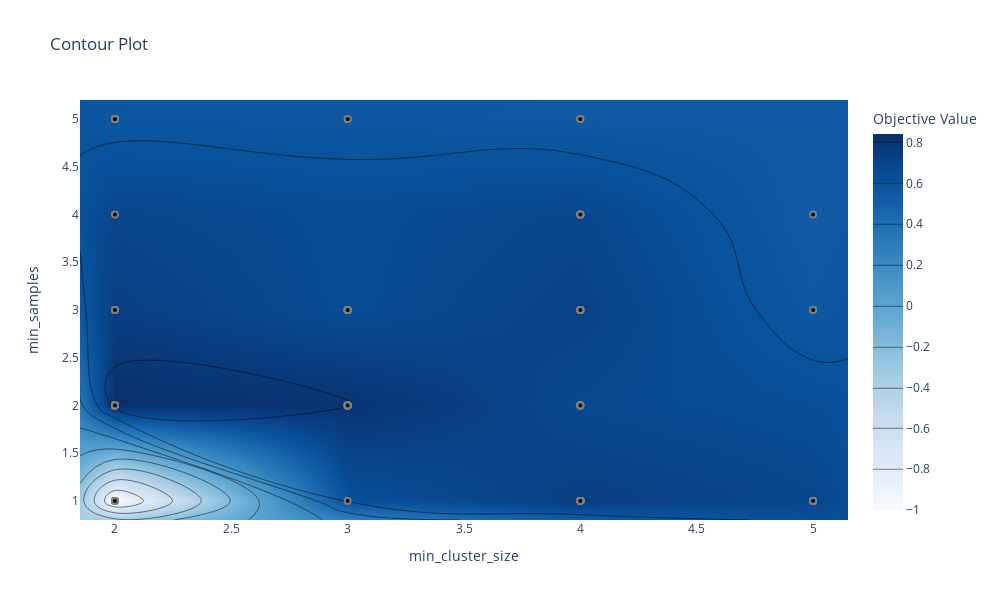

In [29]:
gc.collect()
fig = optuna.visualization.plot_contour(
    study=study, params=["min_cluster_size", "min_samples"]
)
fig.update_layout(width=1000, height=600)
fig.show("png")

### Step 4.2 Build final model based on best parameters

Finally, with the optimal hyperparameters known, a pipeline can be created.

In [30]:
def gimme_pipeline(n_neighbors, min_cluster_size, min_samples):
    return make_pipeline(
        StandardScaler(),
        umap.UMAP(n_jobs=-1, n_components=100, n_neighbors=n_neighbors, min_dist=0.0),
        hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            prediction_data=True,
            core_dist_n_jobs=8,
        ),
    )


try:
    with open("step_04.2_reducer_cluster_pipeline.pkl", "rb") as f:
        reducer_cluster_pipeline = pickle.load(f)
except:
    reducer_cluster_pipeline = gimme_pipeline(**study.best_params)
    reducer_cluster_pipeline.fit(corpus_embeddings)

    # pickle it
    with open("step_04.2_reducer_cluster_pipeline.pkl", "wb") as f:
        pickle.dump(reducer_cluster_pipeline, f)

In [31]:
reducer_cluster_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('umap',
                 UMAP(min_dist=0.0, n_components=100, n_neighbors=2, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('hdbscan',
                 HDBSCAN(core_dist_n_jobs=8, min_cluster_size=2, min_samples=2,
                         prediction_data=True))])

Sanity check:

In [32]:
len(reducer_cluster_pipeline["hdbscan"].labels_)

214

In [33]:
print(
    f'There are {len(set(reducer_cluster_pipeline["hdbscan"].labels_))} topics/clusters including the noise cluster'
)

There are 43 topics/clusters including the noise cluster


## Step 5: Explore the Topics

In [34]:
clusterer = reducer_cluster_pipeline["hdbscan"]

### Step 5.1 Topic Distributions

- From the bar chart below, it can be seen that most topics consist of or span an average of 2-3 episodes
- There is a noise cluster (label -1) that has 24 episodes in them that the algorithm didn't know group with other episodes
- The largest topic group outside fo the noise group is topic 27, with 10 episodes

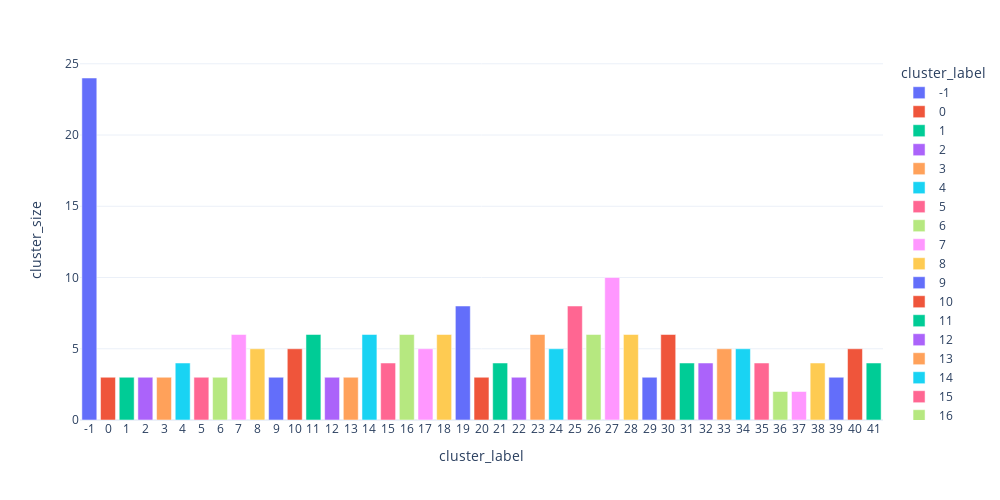

In [35]:
gc.collect()
fig = px.bar(
    pl.Series(reducer_cluster_pipeline["hdbscan"].labels_)
    .value_counts()
    .rename({"": "cluster_label", "counts": "cluster_size"})
    .sort(by="cluster_label")
    .with_columns(pl.col("cluster_label").cast(pl.Utf8)),
    x="cluster_label",
    y="cluster_size",
    color="cluster_label",
    width=1000,
    height=500,
    template="plotly_white",
)
fig.show("png")

### Step 5.2 Plot the 300D corpus embeddings clusters on 2D

The function below is to reduce the 300 dimensional embeddings of the corpus down to 2 dimensionals so that it can be plotted (with the topic / cluster label as the color dimension).

In [36]:
def make_2d_embeddings(corpus: np.ndarray, nn: int) -> np.ndarray:
    pipe = make_pipeline(
        StandardScaler(),
        umap.UMAP(n_components=2, n_neighbors=nn, min_dist=0.0, n_jobs=-1),
    )
    return pipe.fit_transform(corpus)

- In order to best reduce the 300D embeddings down to 2D for plotting, it is needed to select the optimal number of neighbors for the UMAP algorithm such that the [trustworthiness](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.trustworthiness.html) score is the highest.
- The `trustworthiness score` ranges from 0 to 1 and is an indicator to how much the local structure between the high dimensional data points is preserved in the low dimensional representation
- The code below is to tune the `n_neighbors` hyperparameter from (2 to 20)

In [37]:
nn = np.arange(2, 21)
t_score = []

for n in tqdm(nn):
    try:
        X = make_2d_embeddings(corpus_embeddings, n)
        t_score.append(
            trustworthiness(X=corpus_embeddings, X_embedded=X, n_neighbors=n)
        )
    except:
        t_score.append(-1)
        continue

max_nn = nn[np.argmax(t_score)]
max_t_score = np.max(t_score)
print(max_nn, max_t_score)

  0%|          | 0/19 [00:00<?, ?it/s]

3 0.9536138562208409


In [38]:
corpus_embeddings_2d = make_2d_embeddings(corpus_embeddings, max_nn)
titles = [t["title"].partition(" ")[-1].replace(" Transcript", "") for t in transcripts]
episodes = [t["title"].partition(" ")[0] for t in transcripts]
corpus_2d_df = pl.DataFrame(corpus_embeddings_2d).rename(
    {"column_0": "pc_1", "column_1": "pc_2"}
)
corpus_2d_df = (
    pl.concat(
        [
            corpus_2d_df,
            pl.DataFrame(
                [clusterer.labels_, clusterer.probabilities_, episodes, titles],
                schema=["label", "probability", "episode", "title"],
            ),
        ],
        how="horizontal",
    )
    .with_columns(pl.col("label").cast(pl.Utf8))
    .sort(by="label")
)

- Not much insight is gained from the 2D projection of the 300D embeddings since it appears that despite the high trustworthiness score of 0.95, most topics are very close to each other on the 2D representation

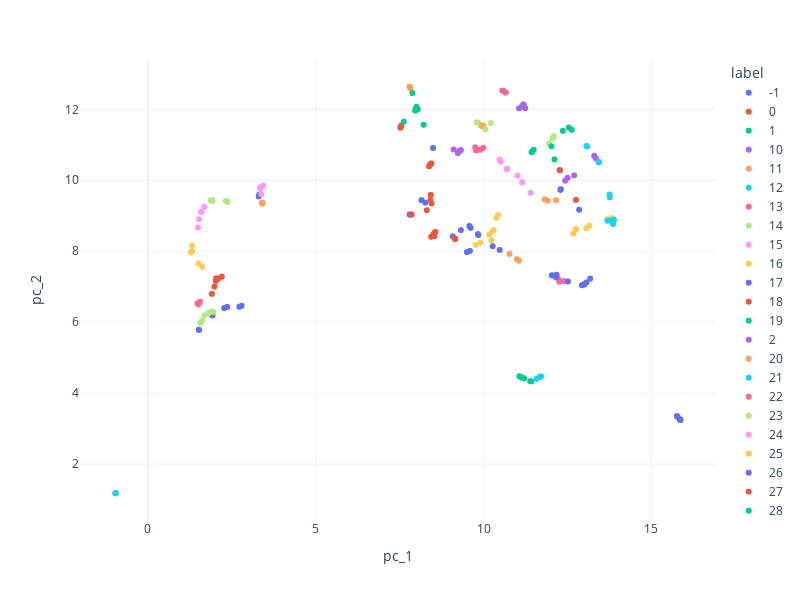

In [39]:
gc.collect()
fig = px.scatter(
    corpus_2d_df,
    x="pc_1",
    y="pc_2",
    color="label",
    # text="title",
    hover_name="title",
    width=800,
    height=600,
    template="plotly_white",
)
fig.update_traces(textposition="top center")
fig.show("png")

### Step 5.3 Plot / build a treemap to give an overview of how the episodes are aranged in the topics, along with their topic / cluster probabilities

- In the below map, the outer container is the Cluster label (topic) with the inner boxes representing the episode number that belong to that topic
- The size of an inner box in relation to other inner boxes represent the probability that the particular episode belonging in that topic / cluster
- Since this is made to be shown on github, one cannot easily see the episodes' titles, however if this is viewed locally, one can hover over above each box to see the titles

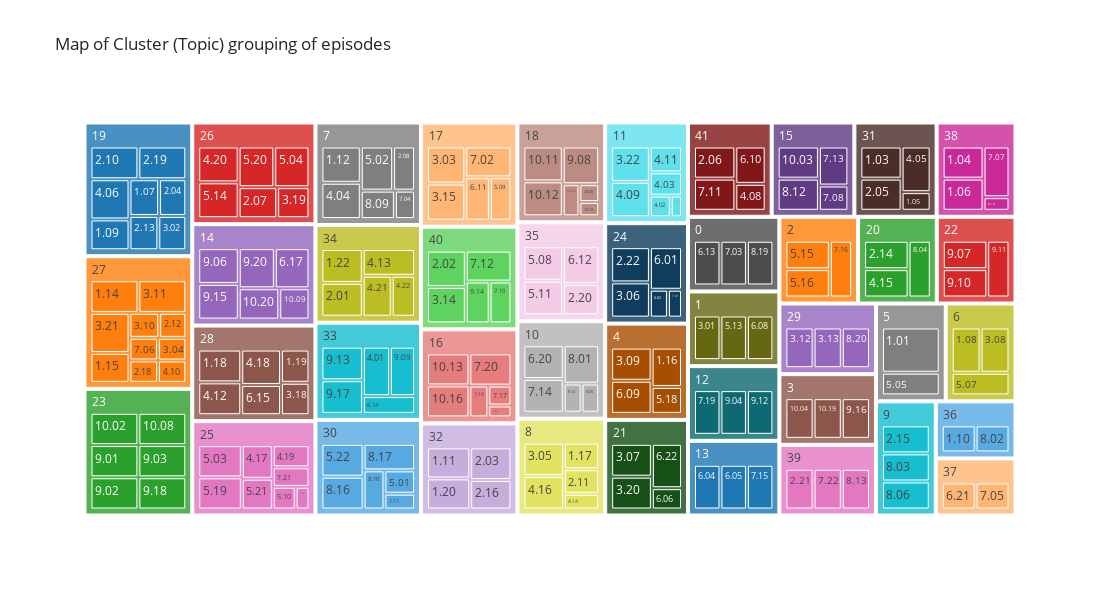

In [50]:
gc.collect()
fig = px.treemap(
    corpus_2d_df,
    path=["label", "episode"],
    values="probability",
    hover_data="title",
    hover_name="episode",
    title="Map of Cluster (Topic) grouping of episodes",
    width=1100,
    height=600,
    template="simple_white",
)
# for github
fig.show("png")

# for local viewing with title hover capability
# fig.show()

- The `corpus_2d_df` DataFrame contains the episodes and their corresponding topic label (along with the probability belonging in that topic).

- To find out the episodes belonging to a particular topic label, it can be filtered like so:

In [41]:
corpus_2d_df.filter(pl.col("label") == "10")

pc_1,pc_2,label,probability,episode,title
f32,f32,str,f64,str,str
11.194038,12.106586,"""10""",1.0,"""6.20""","""""Memento"""""
11.054143,12.028565,"""10""",1.0,"""7.14""","""""Fallout"""""
11.242303,12.033409,"""10""",1.0,"""8.01""","""""New Order Par…"
11.148561,12.095783,"""10""",0.375806,"""8.05""","""""Icon"""""
11.188143,12.141034,"""10""",0.384049,"""8.14""","""""Full Alert"""""


In [42]:
corpus_2d_df.filter(pl.col("label") == "27")

pc_1,pc_2,label,probability,episode,title
f32,f32,str,f64,str,str
8.563656,8.546177,"""27""",1.0,"""1.14""","""""Hathor"""""
9.14871,8.359907,"""27""",0.743906,"""1.15""","""""Singularity"""""
9.154276,8.340707,"""27""",0.432185,"""2.12""","""""The Tok'ra Pa…"
8.437661,8.408399,"""27""",0.409189,"""2.18""","""""Holiday"""""
8.3765,10.391416,"""27""",0.409123,"""3.04""","""""Legacy"""""
8.533099,8.427322,"""27""",0.473186,"""3.10""","""""Forever In A …"
8.504692,8.473476,"""27""",1.0,"""3.11""","""""Past And Pres…"
8.54163,8.518397,"""27""",1.0,"""3.21""","""""Crystal Skull…"
8.44462,10.475533,"""27""",0.401879,"""4.10""","""""Beneath The S…"


### Step 5.4 Extract most relevant words for each Cluster or Topic

- The function below is to get the top `n` words for each topic
- This is done by using what is called a class-TF-IDF score
- All documents belonging to the same Topic are concatenated together, to build a topic corpus
- Then TF-IDF is run on this topic corpus and the top `n` highest scores for each topic is presented
- The stopwords set was updated with some common words used in the show that have little information value to the topics

In [43]:
def get_top_n_words(
    tokenized_corpus: list[list[str]], labels: list[str], n
) -> tuple[dict, np.ndarray]:
    # update stopwords with some common words used in the show
    # that have little indicative value to the topics
    stopwords = text.ENGLISH_STOP_WORDS.union(
        {
            "colonel",
            "stargate",
            "yeah",
            "know",
            "major",
            "lieutenant",
            "sir",
            "uh",
            "oh",
            "yes",
            "like",
            "right",
            "ok",
            "okay",
            "sure",
            "got",
            "look",
            "looks",
            "let",
            "going",
            "think",
            "walks",
            "want",
            "come",
            "away",
            "voiceover",
            "people",
            "phone",
            "turns",
            "daniel",
            "carter",
            "teal'c",
            "o'neill",
            "jack",
            "hammond",
            "landry",
        }
    )

    # initialize a topic_corpus dict with empty lists
    topic_corpus = {label: [] for label in set(labels)}

    # fill the topic_corpus with all the episodes belonging to each topic or cluster group
    for i, episode in enumerate(tokenized_corpus):
        topic_corpus[labels[i]].extend(episode)

    # for each topic label, join all the tokens together to form a corpus of strings
    for k, v in topic_corpus.items():
        topic_corpus[k] = " ".join(v)

    # create list of the topic strings to prepare for the topic/class tf-idf
    topic_corpus_list = [v for v in topic_corpus.values()]

    vectorizer = TfidfVectorizer(
        token_pattern=r"(?u)\b\w+[']?\w+\b",
        stop_words=list(stopwords),
        ngram_range=(1, 3),
    )
    X = vectorizer.fit_transform(topic_corpus_list)

    print(
        f"Transformed matrix shape: {X.shape}\nlength of features vector: {len(vectorizer.get_feature_names_out())}"
    )
    print(f"Output top {n} words for each of the {X.shape[0]} clusters")
    highest_n_words = vectorizer.get_feature_names_out()[
        np.argsort(X.toarray(), axis=1)[:, : -(n + 1) : -1]
    ]

    scores_n_words = np.sort(X.toarray(), axis=1)[:, : -(n + 1) : -1]

    res = {
        l: np.c_[w, s] for l, w, s in zip(set(labels), highest_n_words, scores_n_words)
    }

    return (res, X)

In [47]:
top_20_words_per_topic, _ = get_top_n_words(tokenized_corpus, clusterer.labels_, n=20)

Transformed matrix shape: (43, 881271)
length of features vector: 881271
Output top 20 words for each of the 43 clusters


In [48]:
# example of top 20 words in topic 4
top_20_words_per_topic.get(4)

array([['kytano', 0.41510364606826783],
       ['rogers', 0.3076650553211867],
       ['jaffa', 0.23202160189142457],
       ['malek', 0.15838413114850378],
       ["bra'tac", 0.13945928637291205],
       ['hanno', 0.1367400245871941],
       ['artok', 0.10255501844039557],
       ['apophis', 0.0897105223261892],
       ["rak'nor", 0.08930333312708036],
       ["tok'ra", 0.08486108474880406],
       ['ashrak', 0.0807180139928208],
       ['ocker', 0.07813715690696806],
       ['warriors', 0.07462061188532879],
       ['nelson', 0.06895448936438586],
       ['cor ai', 0.06837001229359704],
       ['vocume', 0.06837001229359704],
       ['final challenge', 0.06348643998691154],
       ['weapons', 0.062073606627861655],
       ['weapon', 0.05968616021909775],
       ['imhotep', 0.058602867680226045]], dtype=object)

In [49]:
# example of top 20 words in topic 27
top_20_words_per_topic.get(27)

array([["ke'ra", 0.22587774469662986],
       ["ma'chello", 0.2120891039539961],
       ['brenna', 0.16543158766513733],
       ['thera', 0.1463433275499292],
       ['room', 0.14075365550641436],
       ['jonah', 0.13043644412058905],
       ['carlin', 0.12725506743472104],
       ['fraiser', 0.12500021004880327],
       ['nick', 0.11626360193188272],
       ['calder', 0.11452956069124892],
       ["goa'uld", 0.11275845330624355],
       ['skull', 0.10613933749227644],
       ['dr', 0.09657694476923093],
       ['pharrin', 0.09544130057604078],
       ['kegan', 0.09544130057604078],
       ['linea', 0.08024993122583636],
       ['garshaw', 0.07927063768082912],
       ['workers', 0.07719224544892832],
       ["sha're", 0.07506676575635113],
       ['tryan', 0.0731716637749646]], dtype=object)